# ML Challenge - Customer Segmentation

This challenge will analyse a dataset of 8500 customers showing 18 features related to their credit card transactions. THe goal is to find a meaningful customer segmentation to define a different strategy for each.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest

from pyod.models.iforest import IForest
from pyod.models import cblof


plt.rcParams["figure.figsize"] = (20,15)

## Data reading and cleaning

In [2]:
# Read data, drop column_id
data = pd.read_csv('../data/card_transactions.csv').drop(columns='customer_id')
data.head()

,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc
0,9.298409,107.60,0.000000,0.00,0.909091,107.6,0.909091,0.000000,0.818182,0.000000,0,10,1000.0,11,89.868853,89.711672,0.428571
1,52.666422,150.30,0.000000,0.00,1.000000,150.3,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,6,54.722514,82.955180,0.000000
2,1360.795674,0.00,462.861443,0.00,1.000000,0.0,0.000000,0.000000,0.000000,0.272727,6,0,1500.0,11,303.031979,443.781316,0.000000
3,2021.641161,363.18,0.000000,363.18,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,0,13,2000.0,12,704.240770,795.859808,0.000000
4,22.322374,95.00,1162.045833,95.00,0.363636,0.0,0.083333,0.083333,0.000000,0.166667,3,1,2500.0,12,4094.261427,40.142262,0.000000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   balance_account                   8500 non-null   float64
 1   purchases_amount                  8500 non-null   float64
 2   paid_advance                      8500 non-null   float64
 3   full_purchases                    8500 non-null   float64
 4   balance_frequency_update          8500 non-null   float64
 5   installments                      8500 non-null   float64
 6   purchases_frequency               8500 non-null   float64
 7   full_purchases_frequency          8500 non-null   float64
 8   purchases_installments_frequency  8500 non-null   float64
 9   cash_advance_frequency            8500 non-null   float64
 10  nr_cash_advances                  8500 non-null   int64  
 11  nr_purchases                      8500 non-null   int64  
 12  credit

Since there are a total of 298 NaN on the feature 'min_payments', the KNN Imputer is used to fill this values with 5 neighbors

In [4]:
# Impute missing NaN
imputer = KNNImputer(n_neighbors=5)

X_imputed= pd.DataFrame(imputer.fit_transform(data))
X_imputed_renamed = X_imputed.set_axis(data.columns, axis=1)
X_imputed_renamed

,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc
0,9.298409,107.60,0.000000,0.00,0.909091,107.60,0.909091,0.000000,0.818182,0.000000,0.0,10.0,1000.0,11.0,89.868853,89.711672,0.428571
1,52.666422,150.30,0.000000,0.00,1.000000,150.30,1.000000,0.000000,0.833333,0.000000,0.0,6.0,1000.0,6.0,54.722514,82.955180,0.000000
2,1360.795674,0.00,462.861443,0.00,1.000000,0.00,0.000000,0.000000,0.000000,0.272727,6.0,0.0,1500.0,11.0,303.031979,443.781316,0.000000
3,2021.641161,363.18,0.000000,363.18,1.000000,0.00,1.000000,1.000000,0.000000,0.000000,0.0,13.0,2000.0,12.0,704.240770,795.859808,0.000000
4,22.322374,95.00,1162.045833,95.00,0.363636,0.00,0.083333,0.083333,0.000000,0.166667,3.0,1.0,2500.0,12.0,4094.261427,40.142262,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,1127.607606,0.00,271.093275,0.00,1.000000,0.00,0.000000,0.000000,0.000000,0.083333,1.0,0.0,8500.0,12.0,662.387331,260.277533,0.000000
8496,21.409828,149.71,0.000000,0.00,1.000000,149.71,0.916667,0.000000,0.916667,0.000000,0.0,11.0,1500.0,12.0,141.974905,150.500248,0.166667
8497,0.000000,0.00,253.887233,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.111111,1.0,0.0,500.0,9.0,2437.932505,119.113995,0.000000
8498,1646.384530,1047.34,146.650389,1047.34,1.000000,0.00,0.583333,0.583333,0.000000,0.166667,2.0,51.0,3000.0,12.0,462.848132,497.408854,0.000000


## Initial EDA

### Correlation Heatmap

for n, ax in enumerate(axs):
    ax.plot(x,y, 'o-')
    ax.set_title(ha[n])
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=40, ha=ha[n])

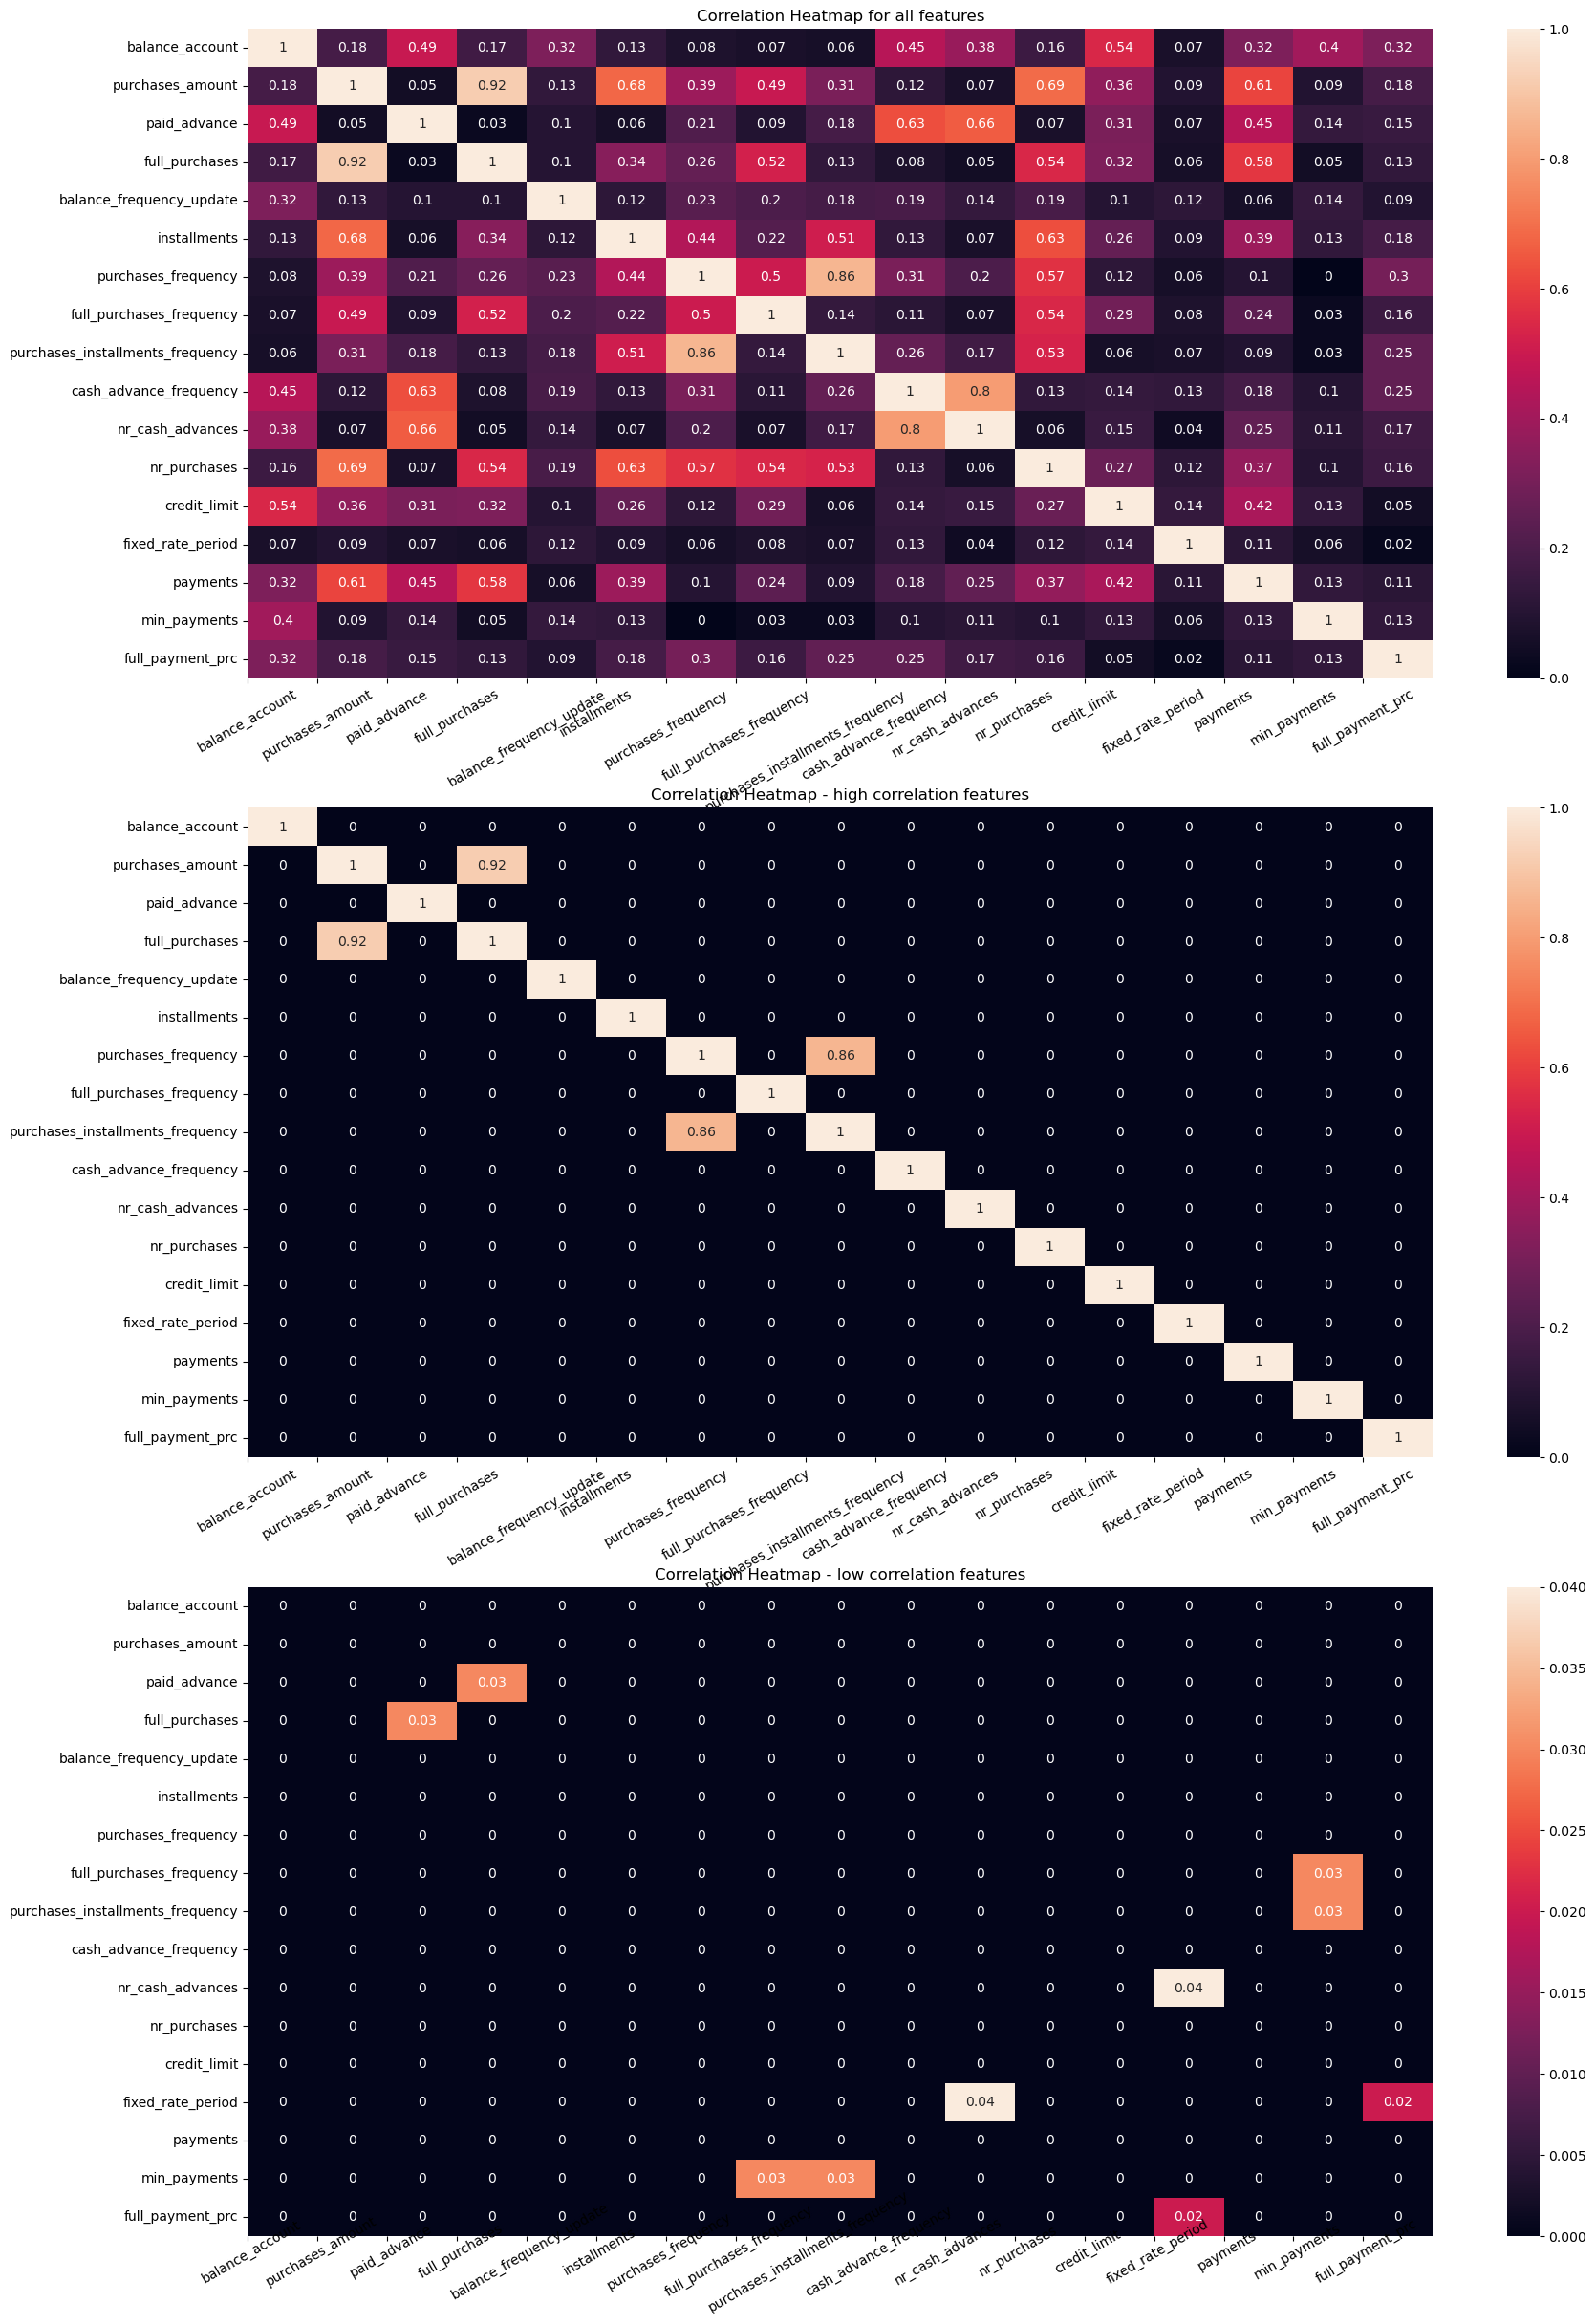

In [29]:
corr=X_imputed_renamed.corr().applymap(lambda x: round(abs(x),2))
corr_high = corr.applymap(lambda x: round(x,2) if x > 0.8 else 0)
corr_low = corr.applymap(lambda x: round(x,2) if x < 0.05 else 0)

fig, axs = plt.subplots(3,1,figsize=(20,30));

x=np.arange(len(corr.columns));
sns.heatmap(corr, annot = True, ax=axs[0]);
axs[0].set_title('Correlation Heatmap for all features');
axs[0].set_xticks(x, ha='center')#,rotation_mode='anchor');
axs[0].set_xticklabels(corr.columns, rotation=30, ha='center');#, ha=ha[n])
sns.heatmap(corr_high, annot = True, ax=axs[1]);
axs[1].set_title('Correlation Heatmap - high correlation features')
axs[1].set_xticks(x);#, ha='center',rotation_mode='anchor')
axs[1].set_xticklabels(corr.columns, rotation=30);#, ha=ha[n])
sns.heatmap(corr_low, annot = True, ax=axs[2]);
axs[2].set_title('Correlation Heatmap - low correlation features');
axs[2].set_xticks(x);#, ha='center',rotation_mode='anchor')
axs[2].set_xticklabels(corr.columns, rotation=30, ha='center',rotation_mode='anchor');#, ha=ha[n])

### Histogram of features

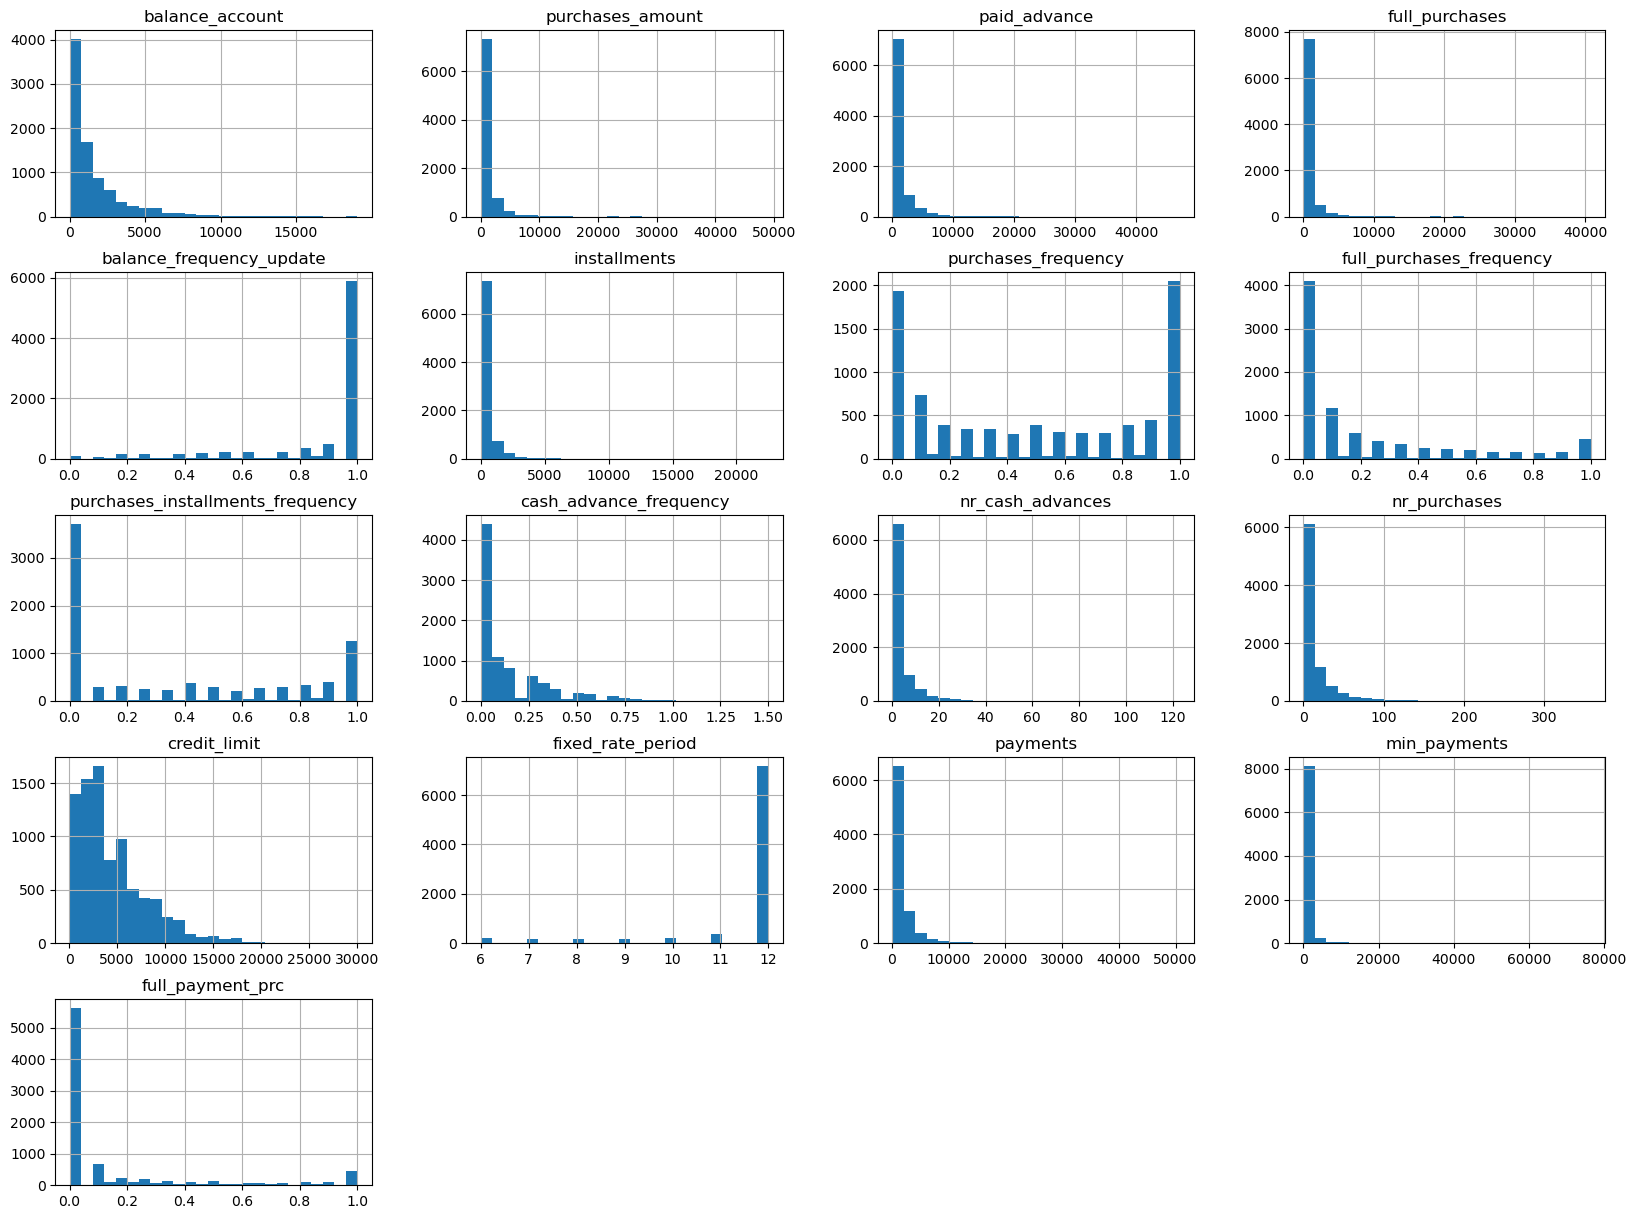

In [7]:
X_imputed_renamed.hist(bins=25);

## Outlier detection

### Outlier Detection with Isolation Forest

In [8]:
# Define percentage of outliers to be detected
n = 0.03
X_outlier = X_imputed_renamed.values

In [9]:
IF_model = IsolationForest(n_estimators=100, contamination=n)
IF_model.fit(X_outlier)
outlier_predictions_IF = IF_model.predict(X_outlier)

In [10]:
pd.DataFrame(outlier_predictions_IF).value_counts()

 1    8245
-1     255
dtype: int64

### Outlier Detection with CBLOF

In [11]:
cblof_model = cblof.CBLOF(contamination=n, random_state=42)
cblof_model.fit(X_outlier)
outlier_predictions_CBLOF = cblof_model.predict(X_outlier)

### Merging Outlier Label to df

In [12]:
outliers_df = X_imputed_renamed.copy(deep=True)
outliers_df['Outlier_CBLOF'] = outlier_predictions_CBLOF
outliers_df['Outlier_IF'] = pd.DataFrame(outlier_predictions_IF).replace([1, -1], [0, 1])
outliers_df.to_csv('../data/transactions_with_outliers.csv', index=False)
outliers_df

,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc,Outlier_CBLOF,Outlier_IF
0,9.298409,107.60,0.000000,0.00,0.909091,107.60,0.909091,0.000000,0.818182,0.000000,0.0,10.0,1000.0,11.0,89.868853,89.711672,0.428571,0,0
1,52.666422,150.30,0.000000,0.00,1.000000,150.30,1.000000,0.000000,0.833333,0.000000,0.0,6.0,1000.0,6.0,54.722514,82.955180,0.000000,0,0
2,1360.795674,0.00,462.861443,0.00,1.000000,0.00,0.000000,0.000000,0.000000,0.272727,6.0,0.0,1500.0,11.0,303.031979,443.781316,0.000000,0,0
3,2021.641161,363.18,0.000000,363.18,1.000000,0.00,1.000000,1.000000,0.000000,0.000000,0.0,13.0,2000.0,12.0,704.240770,795.859808,0.000000,0,0
4,22.322374,95.00,1162.045833,95.00,0.363636,0.00,0.083333,0.083333,0.000000,0.166667,3.0,1.0,2500.0,12.0,4094.261427,40.142262,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,1127.607606,0.00,271.093275,0.00,1.000000,0.00,0.000000,0.000000,0.000000,0.083333,1.0,0.0,8500.0,12.0,662.387331,260.277533,0.000000,0,0
8496,21.409828,149.71,0.000000,0.00,1.000000,149.71,0.916667,0.000000,0.916667,0.000000,0.0,11.0,1500.0,12.0,141.974905,150.500248,0.166667,0,0
8497,0.000000,0.00,253.887233,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.111111,1.0,0.0,500.0,9.0,2437.932505,119.113995,0.000000,0,0
8498,1646.384530,1047.34,146.650389,1047.34,1.000000,0.00,0.583333,0.583333,0.000000,0.166667,2.0,51.0,3000.0,12.0,462.848132,497.408854,0.000000,0,0


In [13]:
outliers_df['Outlier_IF'].value_counts(), outliers_df['Outlier_CBLOF'].value_counts()

(0    8245
 1     255
 Name: Outlier_IF, dtype: int64,
 0    8245
 1     255
 Name: Outlier_CBLOF, dtype: int64)

## END OF NOTEBOOK